# setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = '1'
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import rioxarray


In [2]:
#stations geodataframe
gdf = gpd.read_file('Data/stations.geojson')
# rainfall cleaned data
df_all = pd.read_pickle('Data\ANA_81_10_bet.pkl')
gdf_filtered = gdf[gdf.Code.isin(df_all.Code.unique())]

## IBGE


In [4]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
ibge.drop(0, inplace=True)
gdf_filtered.to_crs(ibge.crs, inplace=True)
gdf.to_crs(ibge.crs, inplace=True)


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot: >

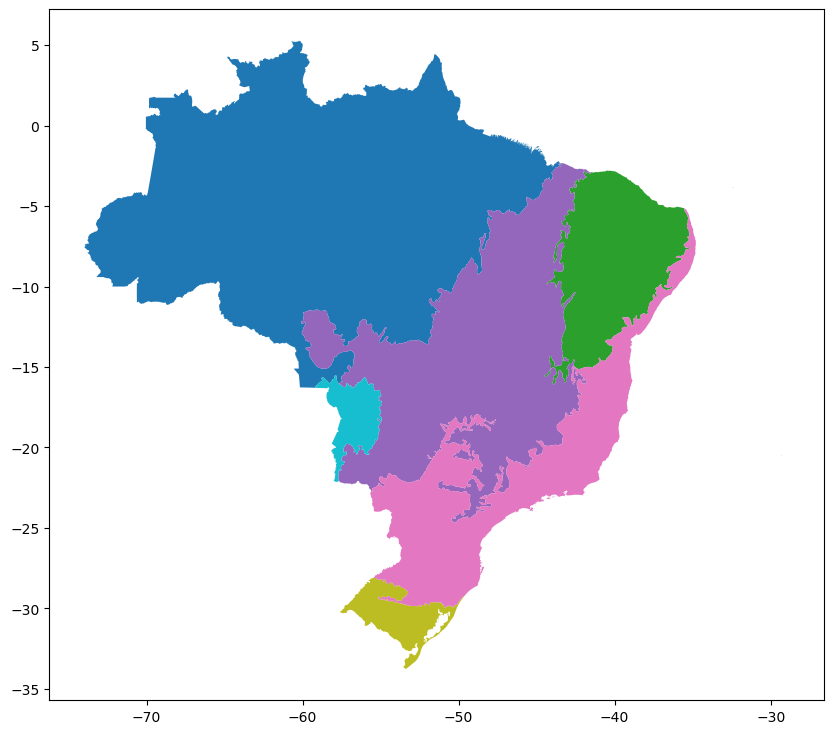

In [16]:
ibge.plot(column='biomas', figsize=(10,10))


In [5]:
gdf_ibge = gpd.sjoin(gdf_filtered, ibge, how='inner', op='intersects')
gdf_ibge_all = gpd.sjoin(gdf, ibge, how='inner', op='intersects')


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
gdf_ibge_all.groupby('biomas').count()

,Code,Name,Latitude,Longitude,Altitude,geometry,index_right,id,objectid,shape_leng,shape_area
biomas,,,,,,,,,,,
AMAZÔNIA,1423,1423,1423,1423,691,1423,1423,0,1423,1423,1423
CAATINGA,3619,3619,3619,3619,2350,3619,3619,0,3619,3619,3619
CERRADO,3735,3735,3735,3735,2739,3735,3735,0,3735,3735,3735
MATA ATLÂNTICA,9703,9703,9703,9703,8003,9703,9703,0,9703,9703,9703
PAMPA,649,649,649,649,383,649,649,0,649,649,649
PANTANAL,75,75,75,75,71,75,75,0,75,75,75


<AxesSubplot: >

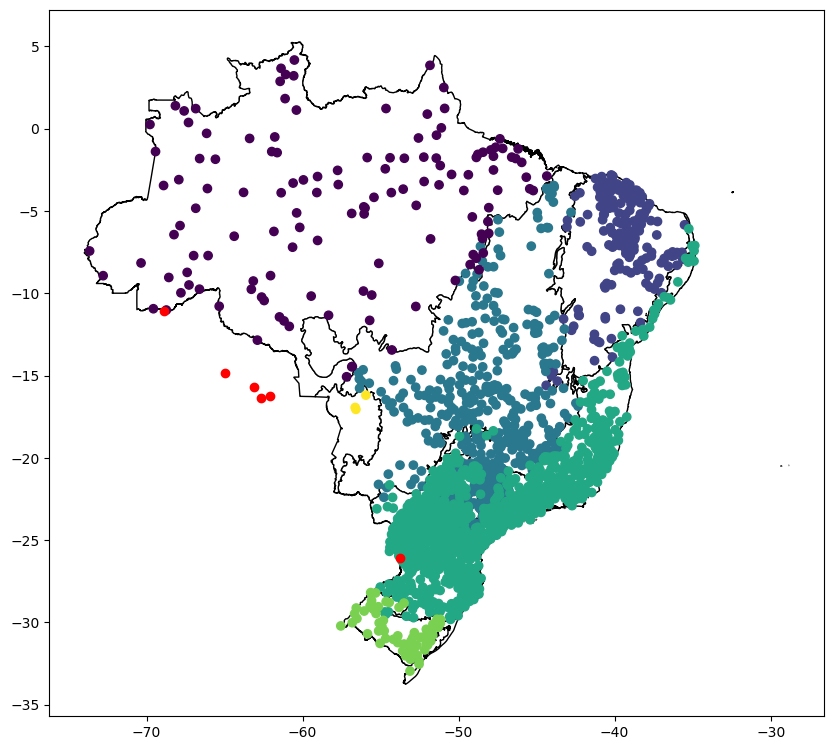

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ibge.plot(ax = ax, color='white', edgecolor='black')
gdf_ibge.plot(ax = ax, column='biomas', cmap='viridis')
gdf_filtered[~gdf_filtered.Code.isin(gdf_ibge.Code.unique())].plot(ax = ax, color='red')

In [22]:
gdf_ibge.groupby('biomas').count()


,Code,Name,Latitude,Longitude,Altitude,geometry,index_right,id,objectid,shape_leng,shape_area
biomas,,,,,,,,,,,
AMAZÔNIA,132,132,132,132,60,132,132,0,132,132,132
CAATINGA,209,209,209,209,187,209,209,0,209,209,209
CERRADO,478,478,478,478,446,478,478,0,478,478,478
MATA ATLÂNTICA,1223,1223,1223,1223,1198,1223,1223,0,1223,1223,1223
PAMPA,60,60,60,60,60,60,60,0,60,60,60
PANTANAL,3,3,3,3,3,3,3,0,3,3,3


In [ ]:

fig, ax = plt.subplots(figsize=(10,10))
ibge[ibge['biomas']=='CERRADO'].plot(ax = ax, color='white', edgecolor='black')
gdf_ibge[gdf_ibge['biomas']=='CERRADO'].plot(ax = ax, color='green')
gdf_est.plot(ax = ax, markersize=5, color='blue')


# cerrado stations climatology

In [5]:
shp_cerrado = ibge[ibge.biomas == 'CERRADO']

In [8]:
# get points from gdf_filtered that are inside shp
gdf_cerrado = gdf_ibge[gdf_ibge.biomas=='CERRADO']
df_cerrado =  df_all[df_all.Code.isin(gdf_cerrado.Code.unique())]
#df_cerrado to pkl
df_cerrado.to_pickle(r'Data\df_cerrado_bet.pkl')


In [43]:
df_clima = df_cerrado.groupby(['Code', df_cerrado.Date.dt.month]).mean()
df_clima = df_clima.unstack()
df_clima.columns = df_clima.columns.droplevel(0)
df_clima.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_clima = df_clima.join(gdf_cerrado.set_index('Code')['geometry'])
df_clima = gpd.GeoDataFrame(df_clima)

C:\Users\luisg\AppData\Local\Temp\ipykernel_9124\2434262258.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clima = df_cerrado.groupby(['Code', df_cerrado.Date.dt.month]).mean()


In [51]:
vmax = 400
vmin = 0
#df_clima[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].max().max()
#df_clima[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].min().min()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []


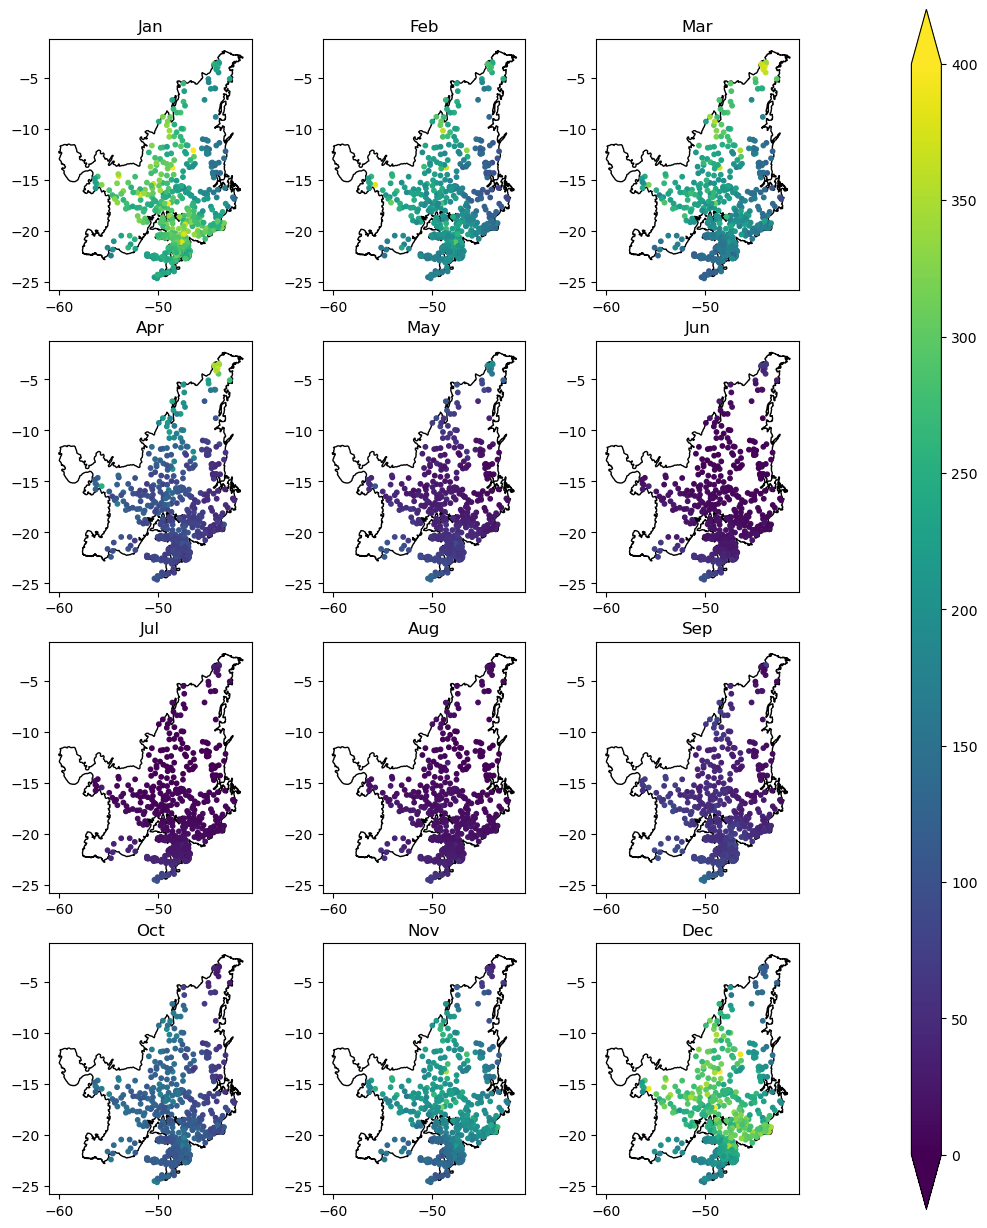

In [53]:
#plot for each month of df_clima
fig, axes = plt.subplots(4, 3, figsize=(10,15))
axes = axes.flatten()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
fig.colorbar(sm, cax=cax, extend='both')

for i, ax in enumerate(axes):
    shp_cerrado.plot(ax = ax, color='white', edgecolor='black')
    df_clima.plot(column=df_clima.columns[i], ax=ax, vmin=vmin, vmax=vmax, markersize=10)
    ax.set_title(df_clima.columns[i])

